# Description

For defining functional groups and reaction mechanisms for polymerization

# Core Imports

In [1]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.amalgamation import portlib, bonding

from polymerist.monomers.substruct.functgroups import FN_GROUP_TABLE
from polymerist.monomers.substruct import specification


# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions, rdDepictor

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH.mkdir(exist_ok=True)

/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Defining target functional groups

### Locate base SMARTS to build off of

hydroxyl [OX2H]


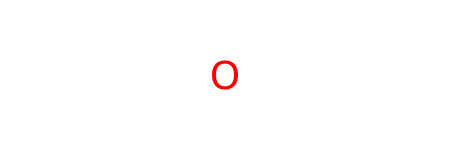

carboxyl [CX3](=O)[OX2H1]


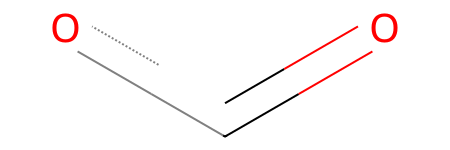

carbamate [NX3,NX4+][CX3](=[OX1])[OX2,OX1-]


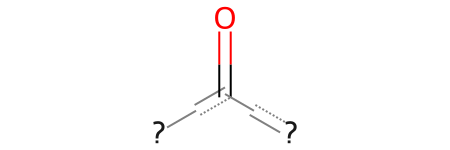

acyl_chloride [CX3](=[OX1])[F,Cl,Br,I]


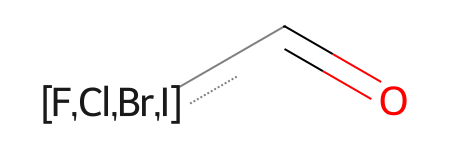

isocyanate [NX3][CX2]#[NX1]


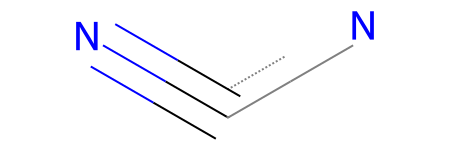

ester [#6][CX3](=O)[OX2H0][#6]


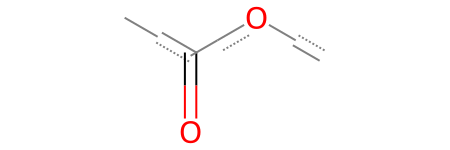

In [2]:
gb = FN_GROUP_TABLE.groupby('group_name')
smarts_keys = {
    'hydroxyl'      : ('Hydroxyl', 156),
    'carboxyl'      : ('Carboxylic acid', 51),
    'carbamate'     : ('Carbamate.', 46),
    'acyl_chloride' : ('Acyl Halide', 237),
    'isocyanate'    : ('Cyanamide', 54),
    'ester'         : ('Ester Also hits anhydrides', 58)
}

smarts_dict, mol_dict = {}, {}
for fn_group_name, (group_key, idx) in smarts_keys.items():
    smarts = gb.get_group(group_key).loc[idx].SMARTS
    rdmol = Chem.MolFromSmarts(smarts)

    print(fn_group_name, smarts)
    display(rdmol)

    smarts_dict[fn_group_name] = smarts 
    mol_dict[fn_group_name] = rdmol 

### Define functional groups (with R-group linkers) as basis for desired reactions

phthalimide


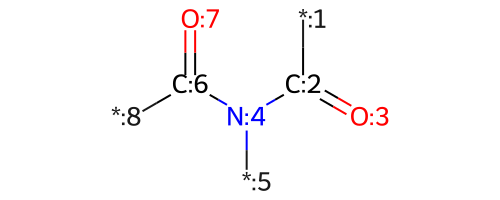

carbamate


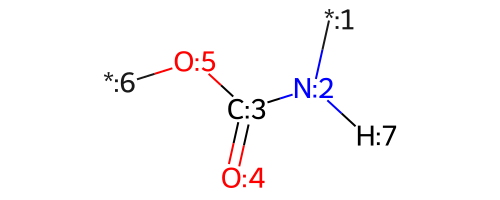

cyclocarbonate


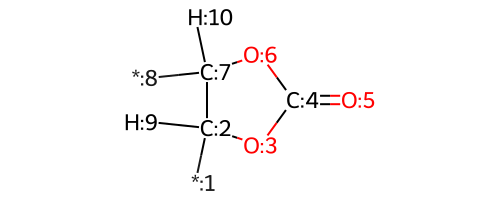

anhydride


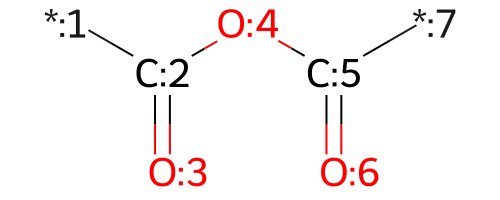

vinyl


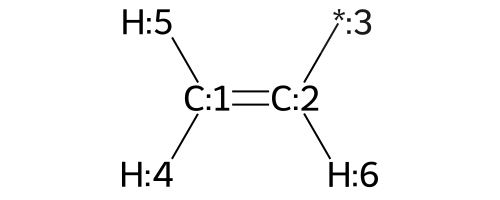

acyl_chloride


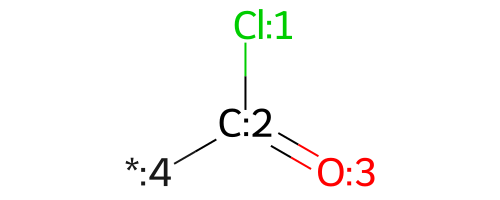

carboxyl


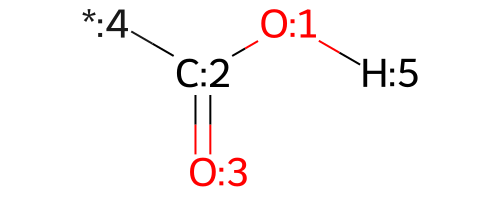

ester


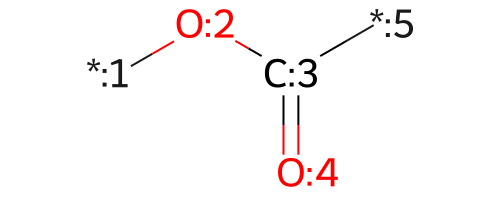

amine


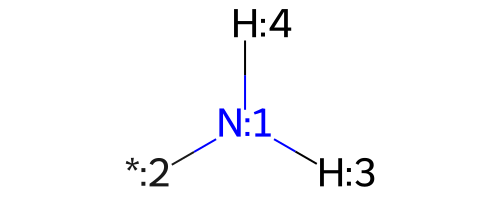

hydroxyl


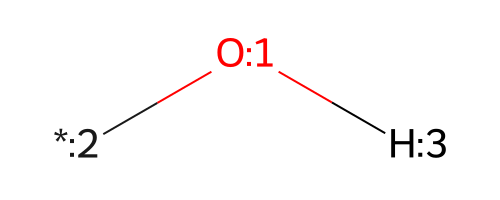

isocyanate


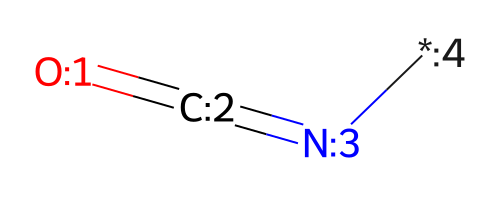

In [3]:
rdkdraw.set_rdkdraw_size(200, 5/2)

fn_group_smiles_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthalimide'   : '*C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    'cyclocarbonate' : '*C1OC(=O)OC1*',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : 'C=C*',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_groups, fn_group_smiles = {}, {}
for group_name, smiles in fn_group_smiles_bare.items():
    smiles_mol = Chem.MolFromSmiles(smiles)
    smiles_mol = Chem.AddHs(smiles_mol)
    smiles_mol = molwise.assign_ordered_atom_map_nums(smiles_mol, in_place=False)
    
    print(group_name)
    display(smiles_mol)

    fn_groups[group_name]       = smiles_mol
    fn_group_smiles[group_name] = Chem.MolToSmiles(smiles_mol)


with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smiles, file, indent=4)

# Defining polymerization reactions

In [4]:
from dataclasses import dataclass, field
from typing import Iterable
from polymerist.rdutils.rdtypes import RDMol


@dataclass
class MechanismSchema:
    '''Encapsulates functional group and bond derangement info for a reaction mechanism'''
    reactive_groups : Iterable[str]
    bond_derangement : dict[int, tuple[int, int]] = field(default_factory=dict)
    rxn_name : str = ''

    def __post_init__(self) -> None: # temporary, saves me having to look up from dict individually 
        # 0) defining functional group targets
        self.reactive_groups = [ 
            fn_groups[group_name]
                for group_name in self.reactive_groups
        ] 

    @property
    def reactants(self) -> RDMol:
        '''Combine cached reactive groups into single, contiguously-numbered Mol for manipulation'''
        # 1) extracting and labelling reactants
        reactants = molwise.assign_contiguous_atom_map_nums(*self.reactive_groups, in_place=False) # needed up-front to display reactants for derangement determination
        return Chem.CombineMols(*reactants) 

    def get_rxn(self, debug_display : bool=False) -> reactions.AnnotatedReaction:
        '''Assemble MDL rxn template from information stored in self'''
        if not self.bond_derangement:
            raise ValueError('Must provide valid ')

        # 2) defining and swapping bonds to form product
        products = bonding.swap_bonds(Chem.RWMol(self.reactants), self.bond_derangement, debug_display=debug_display) # create editable Mol
        rdDepictor.Compute2DCoords(products) # clean up 2D spatial arrangement of product
        Chem.SanitizeMol(products, sanitizeOps=specification.SANITIZE_AS_KEKULE)

        # 3) defining reaction
        return reactions.AnnotatedReaction.from_rdmols(reactant_templates=[self.reactants], product_templates=[products])

In [5]:
rdkdraw.set_rdkdraw_size(400, 3/2)
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups

mechanisms : dict[str, MechanismSchema] = {
    'urethane' : MechanismSchema(
        reactive_groups=['isocyanate', 'hydroxyl'],
        bond_derangement={
            7 : (5, 3),
            2 : (3, 5)
        }
    ),
    'NIPU' : MechanismSchema(
        reactive_groups=['cyclocarbonate', 'amine'],
        bond_derangement= {
            6  : (4, 13),
            11 : (13, 4)
        }
    ),
    'ester' : MechanismSchema(
        reactive_groups=['hydroxyl', 'carboxyl'],
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        }
    ),
    'amine' : MechanismSchema(
        reactive_groups=['amine', 'carboxyl'],
        bond_derangement= {
            1 : (3, 6),
            5 : (6, 3)
        }
    ),
    'carbonate_phosgene' : MechanismSchema(
        reactive_groups=['hydroxyl', 'acyl_chloride'],
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        }
    ),
    'vinyl' : MechanismSchema(
        reactive_groups=['vinyl', 'vinyl'],
        bond_derangement= {
            1  : (2, 8),
            12 : (8, 2)
        }
    ),
    'imide' : MechanismSchema(
        reactive_groups=['amine', 'anhydride'],
        bond_derangement={
            4 : (1, 8),
            6 : (8, 1),
            3 : (1, 8), # doubles up carbonyl transfer - must have target atoms as beginning to maintain canonical derangement form
            9 : (8, 1),
        },
    )
}

urethane {7: (5, 3), 2: (3, 5)}


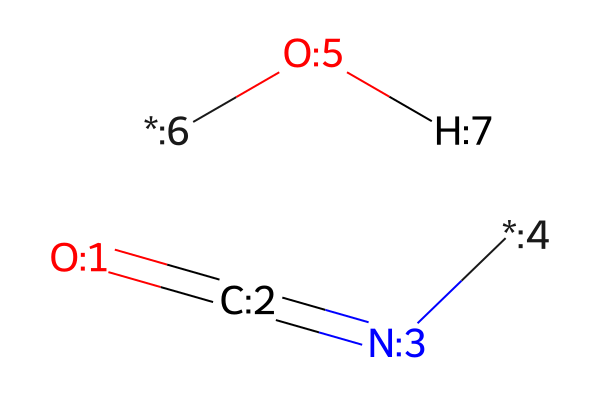

NIPU {6: (4, 13), 11: (13, 4)}


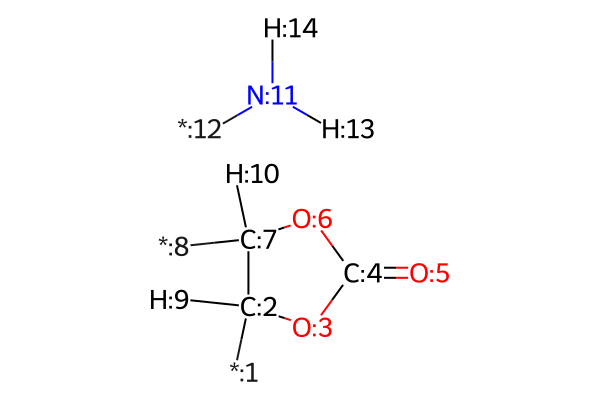

ester {1: (3, 5), 4: (5, 3)}


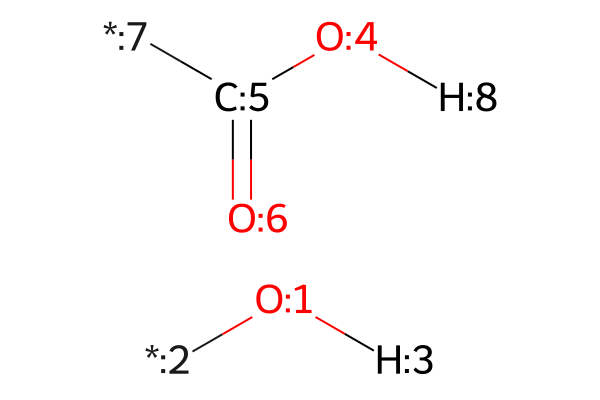

amine {1: (3, 6), 5: (6, 3)}


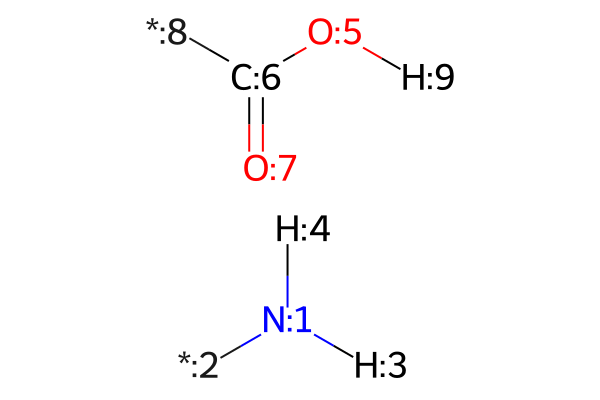

carbonate_phosgene {1: (3, 5), 4: (5, 3)}


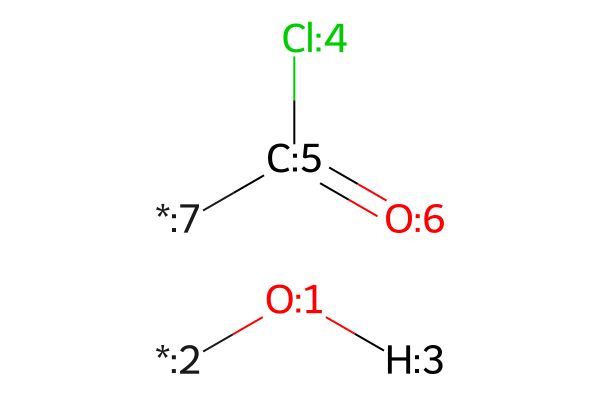

vinyl {1: (2, 8), 12: (8, 2)}


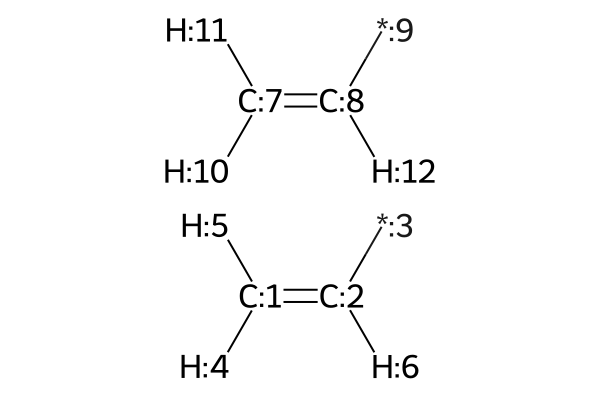

imide {4: (1, 8), 6: (8, 1), 3: (1, 8), 9: (8, 1)}


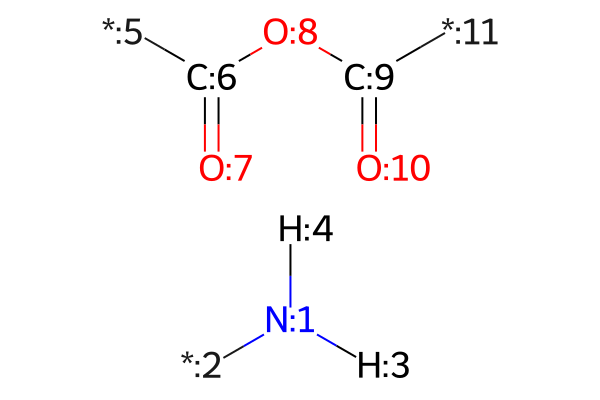

In [6]:
# display mechanism schemata prior to generating reactions (allows for inspection of derangement IDs)
for mech_name, mech_schema in mechanisms.items():
    print(mech_name, mech_schema.bond_derangement)
    display(mech_schema.reactants)

## Generating rxn MDL templates and SMARTS equations and saving to file

urethane


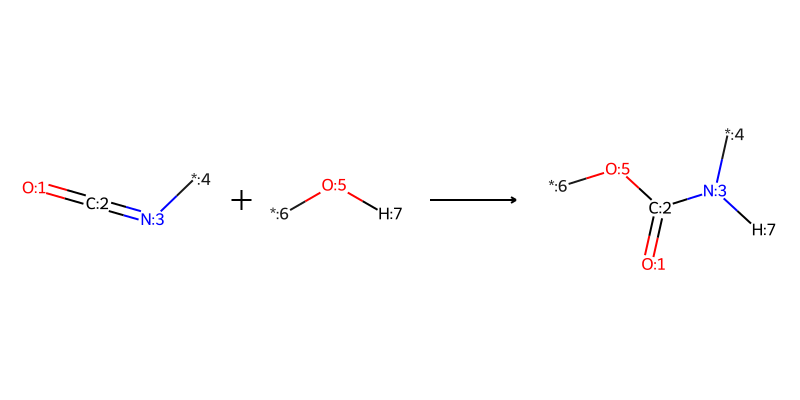

NIPU


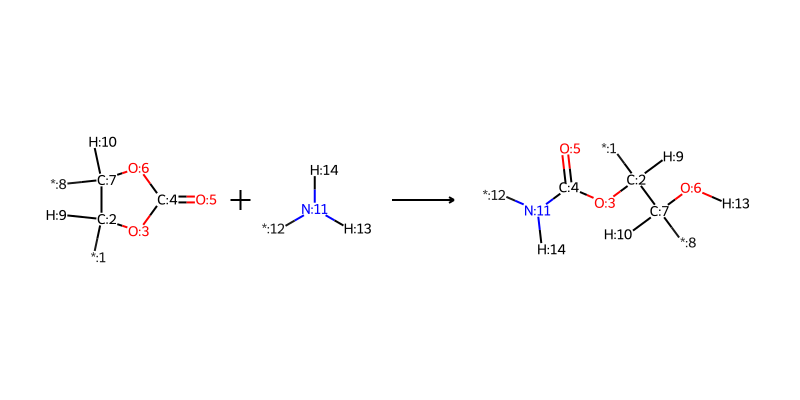

ester


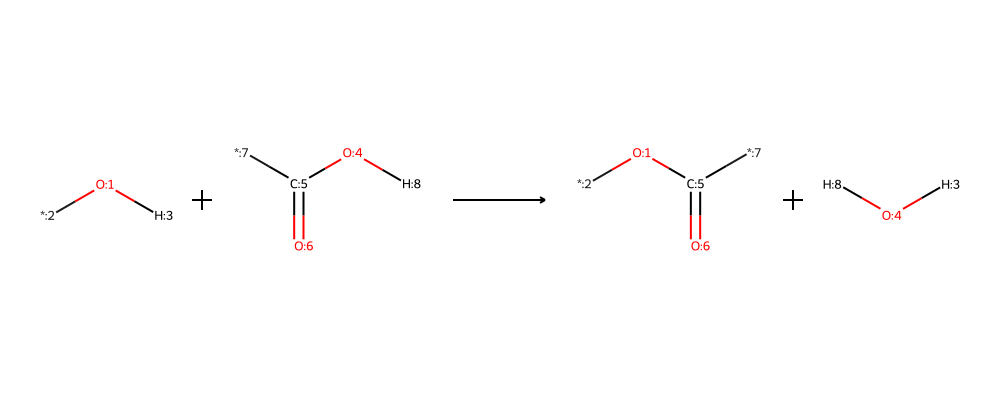

amine


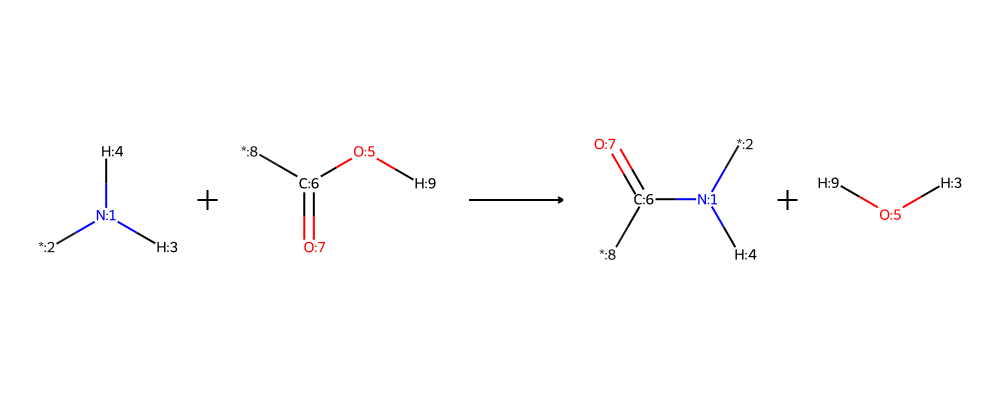

carbonate_phosgene


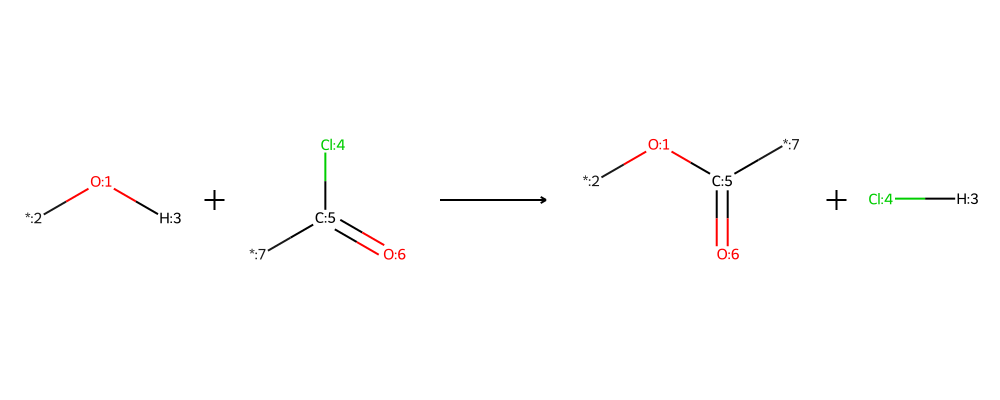

vinyl


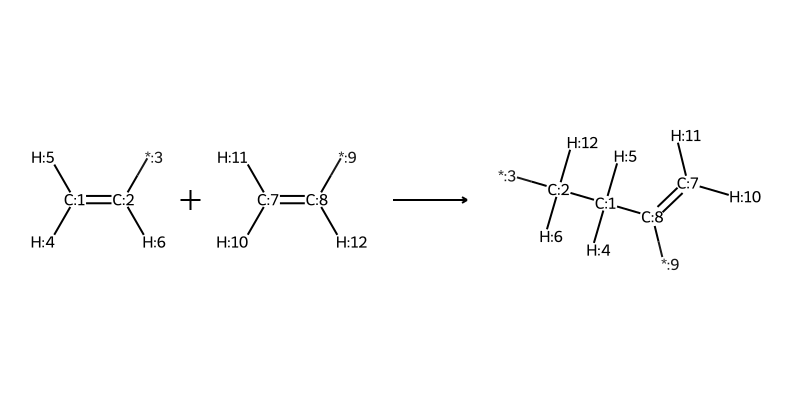

imide


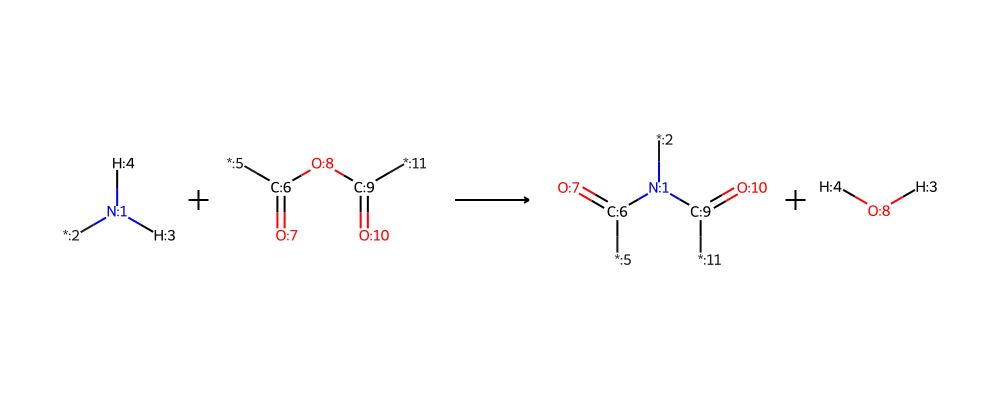

In [7]:
rxns, rxn_smarts = {}, {}
for mech_name, mech_schema in mechanisms.items():
    print(mech_name)
    rxn = mech_schema.get_rxn(debug_display=False)
    display(rxn)

    rxns[mech_name] = rxn
    rxn_smarts[mech_name] = rdChemReactions.ReactionToSmarts(rxn)

In [8]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn')